### Компьютерное зрение
# Лабораторная работа 3. Матчинг изображений по характерным точкам

### На основе материалов курса "Когнитивные технологии", ВШЭ

### Работу выполнил:<span style="color:blue"> Иззатов Эльшан </span>

### Сделанную вторую лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/EgN4Dg_-QoNAsKVMCsYXf70BFch2-cFrfghWddZLVCiXtg)

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Выполним сравнение двух изображений при наличии поворота

**Загружаем изображения для матчинга**

In [4]:
img1 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/2.png', cv2.IMREAD_GRAYSCALE) # шаблон
img2 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/2.png', cv2.IMREAD_GRAYSCALE) # сцена

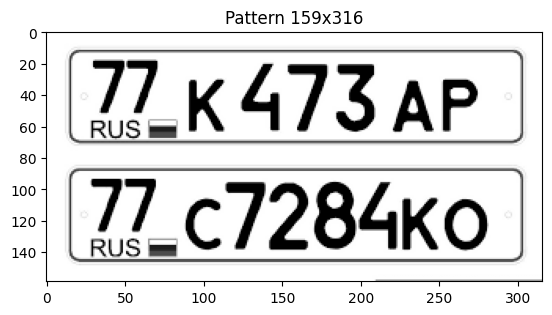

In [5]:
plt.imshow(img1, cmap='gray')
plt.title('Pattern %dx%d' % img1.shape);

**Выполним поворот второго изображения**

In [6]:
(h, w) = img2.shape[:2]
center = (w / 2, h / 2)

M = cv2.getRotationMatrix2D(center, 5, 1.0)
img2 = cv2.warpAffine(img2, M, (w, h))

Text(0.5, 1.0, 'Scene 159x316')

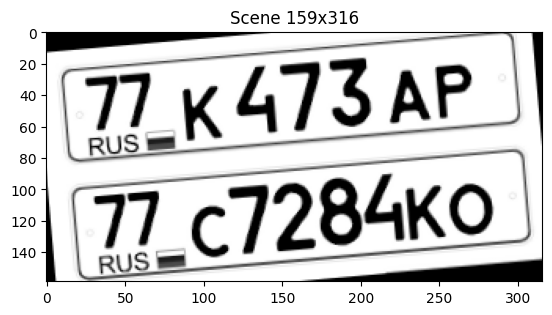

In [7]:
plt.imshow(img2, cmap='gray')
plt.title('Scene %dx%d' % img2.shape)

**Создадим функцию вычисляющую дескрипторы характерных точек ORB**
**Ищем характерные точки и вычисляем для них дескрипторы**

In [8]:
def get_ORB(img):
    # https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF

    # инициализируем детектор точек
    orb = cv2.ORB_create()

    # запускаем поиск точек и вычисление дескрипторов
    kp1, des1 = orb.detectAndCompute(img, None)

    return kp1, des1

In [9]:
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img2)

**Отобразим найденные характерные точки**

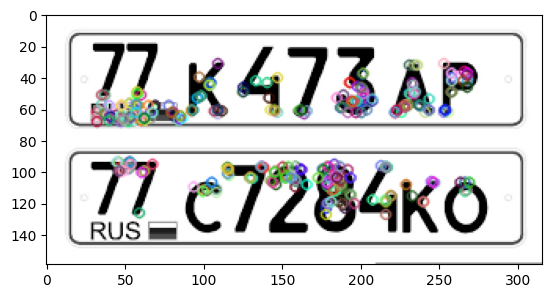

In [10]:
img1_kp = cv2.drawKeypoints(img1, kp1, np.zeros_like(img1))
plt.imshow(img1_kp)

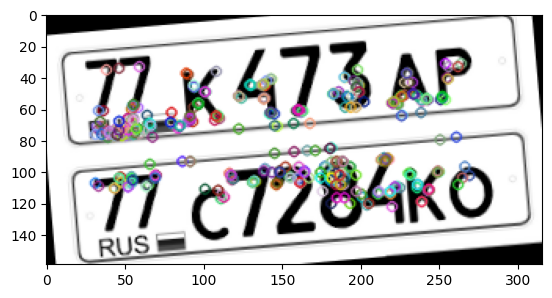

In [11]:
img2_kp = cv2.drawKeypoints(img2, kp2, np.zeros_like(img1))
plt.imshow(img2_kp)

**Создадим функцию выполняющей поиск соответствия между двумя изображениями на основе полного перебора**

In [12]:
def bf_matching(img1, kp1, img2, kp2):
    # матчинг полным перебором - brute force matching

    # мера расстояния - расстояние Хэмминга (количество несовпадающих компонент)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # матчинг
    matches = bf.match(des1, des2)

    # сортируем результат по убыванию расстояния
    matches = sorted(matches, key = lambda x: x.distance)

    # выводим 10 лучших совпадений
    img3 = np.zeros_like(img2)
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:7], img3, flags=2)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(img3),plt.show()

In [13]:
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img2)

**Создадим функцию выполняющей поиск соответствия между двумя изображениями на основе k-ближайших соседей**

In [14]:
def knn_matching(img1, kp1, img2, kp2):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = np.zeros_like(img2)
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,img3,flags=2)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(img3),plt.show()

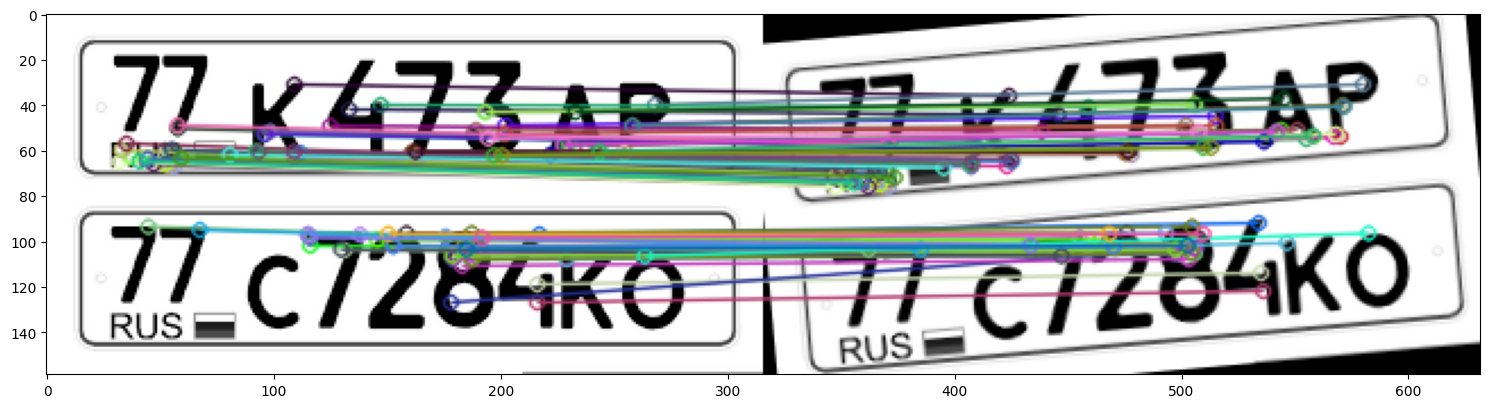

In [15]:
knn_matching(img1, kp1, img2, kp2)

## 2. Выполним сравнение двух изображений при наличии различий в масштабе

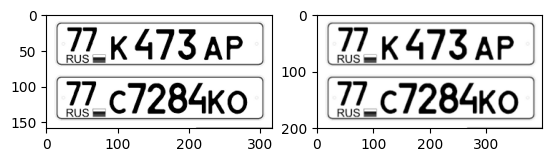

In [16]:
final_wide = 400
r = float(final_wide) / img1.shape[1]
dim = (final_wide, int(img1.shape[0] * r))

# уменьшаем изображение до подготовленных размеров
img4 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)

plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img4, cmap='gray')

In [17]:
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img4)

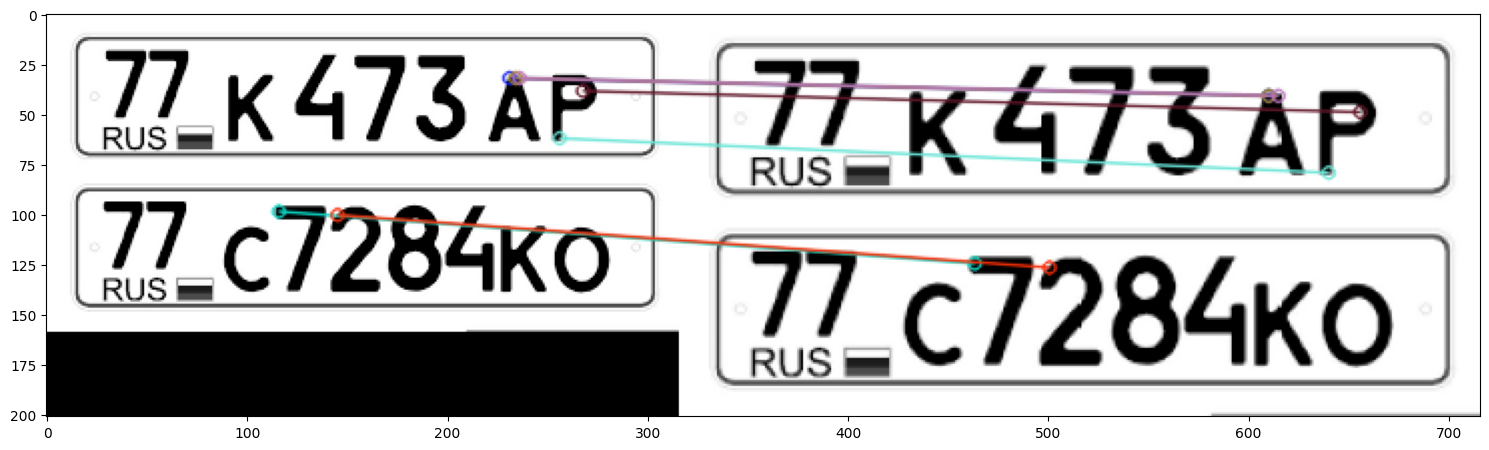

In [18]:
bf_matching(img1, kp1, img4, kp2)

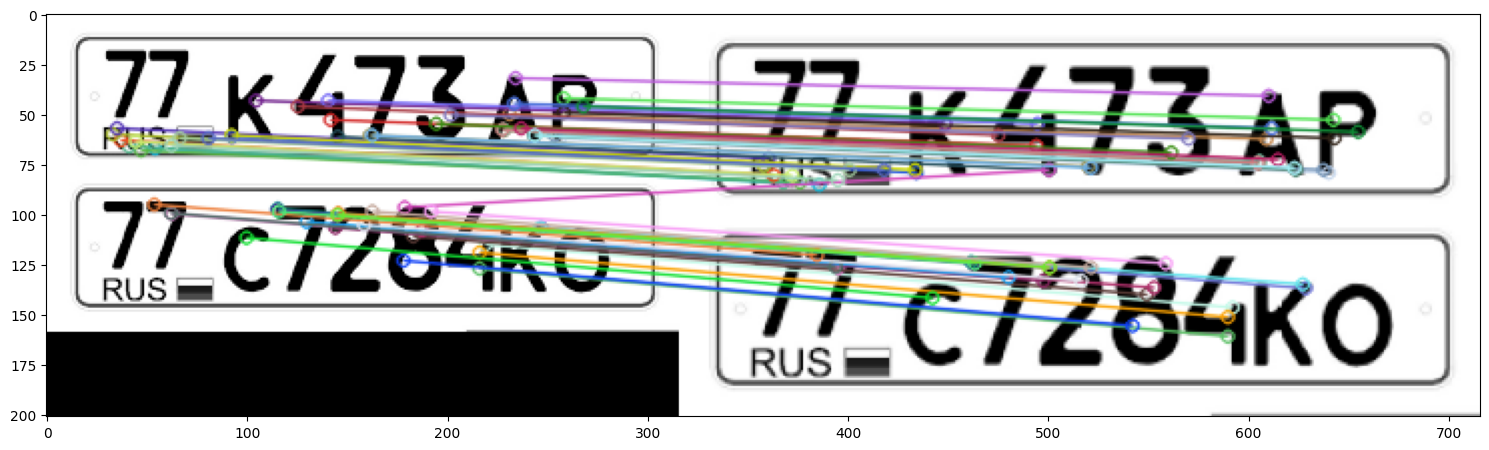

In [19]:
knn_matching(img1, kp1, img4, kp2)

## 3a. Выполним сравнение двух изображений, одно из которых является частью другого (обрезанное изображение)

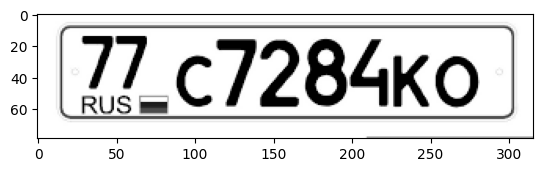

In [20]:
img5 = img1[80:, :]
plt.imshow(img5, cmap='gray')

In [21]:
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img5)

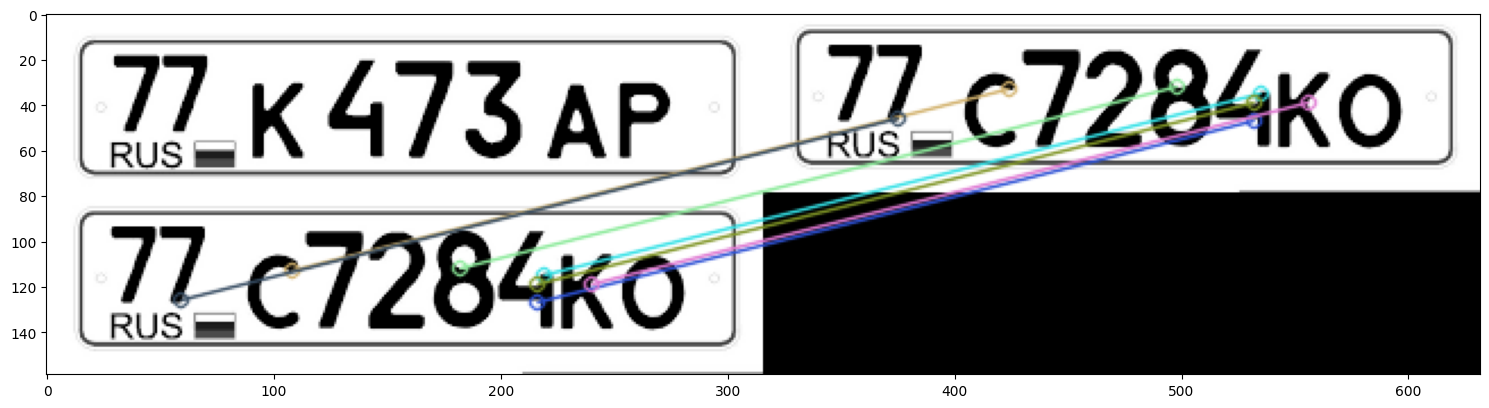

In [22]:
bf_matching(img1, kp1, img5, kp2)

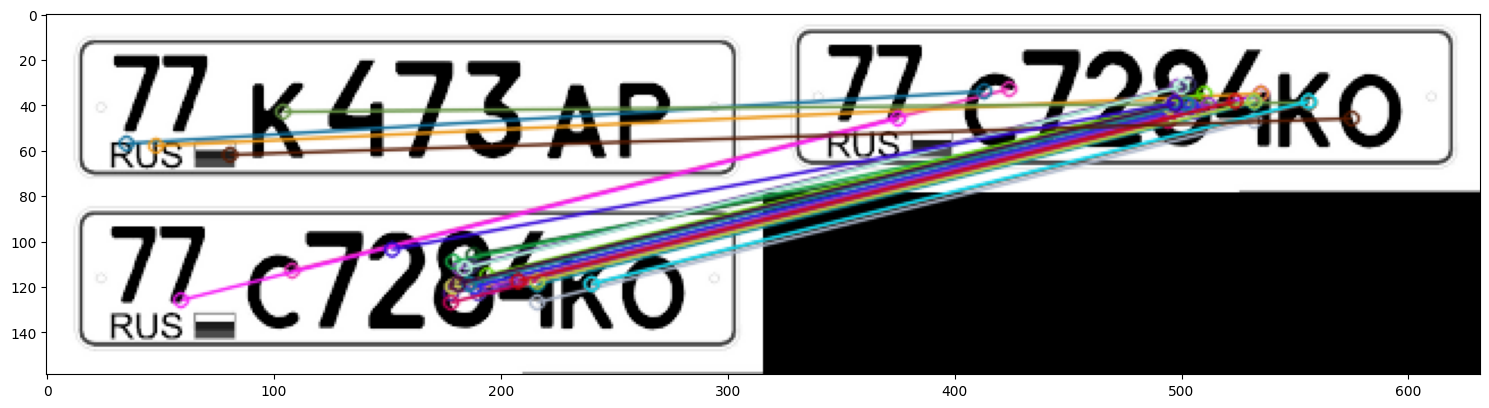

In [23]:
knn_matching(img1, kp1, img5, kp2)

## 3b. И для более сложных изображений

In [24]:
img1 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/vangog0.jpg', cv2.IMREAD_GRAYSCALE)          # шаблон
img2 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/vangog1.jpg', cv2.IMREAD_GRAYSCALE) # сцена

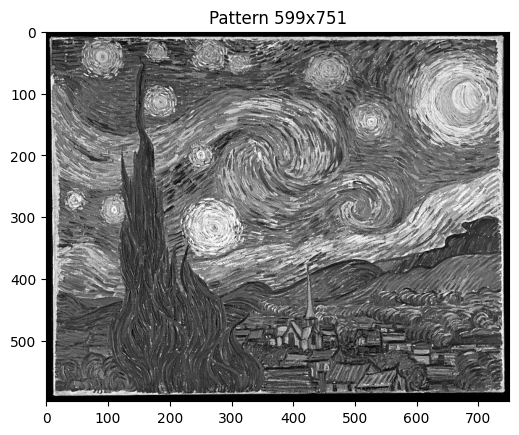

In [25]:
plt.imshow(img1, cmap='gray')
plt.title('Pattern %dx%d' % img1.shape);

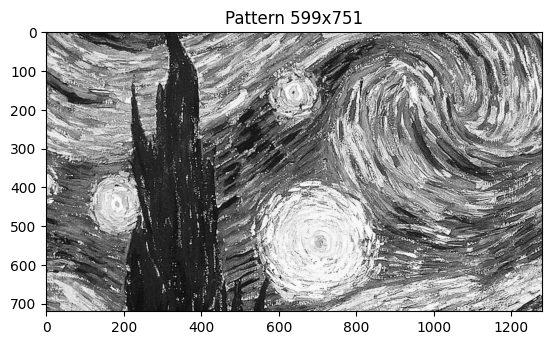

In [28]:
plt.imshow(img2, cmap='gray')
plt.title('Pattern %dx%d' % img1.shape);

In [29]:
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img2)

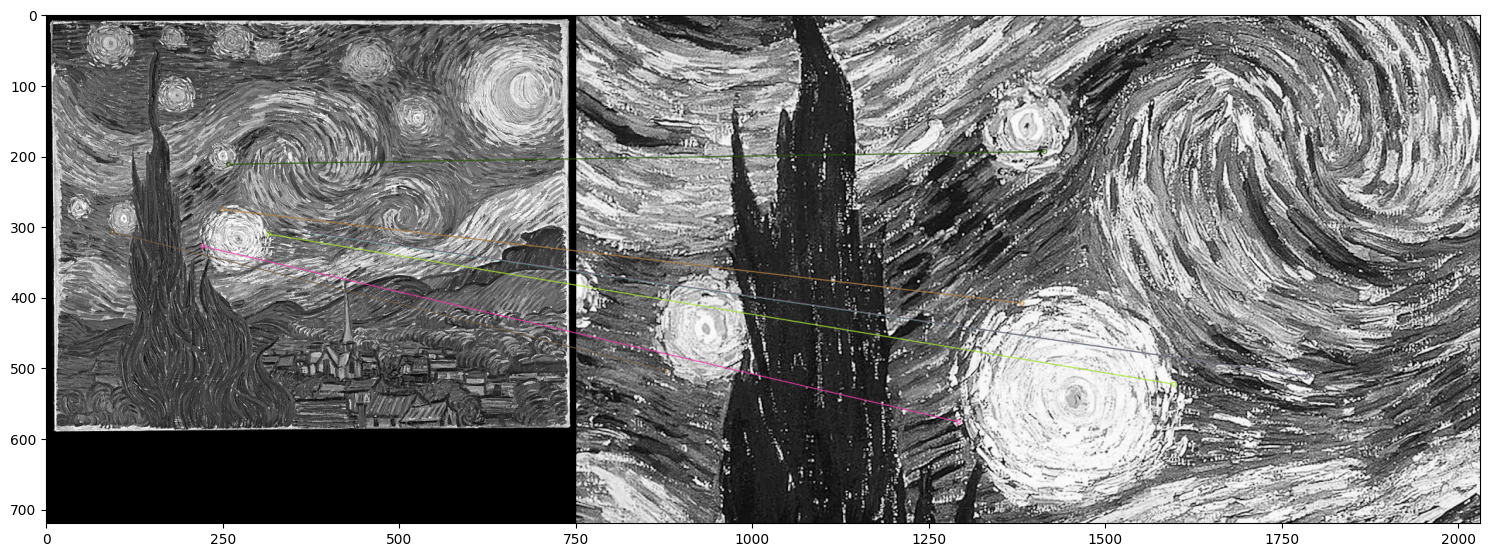

In [ ]:
bf_matching(img1, kp1, img2, kp2)

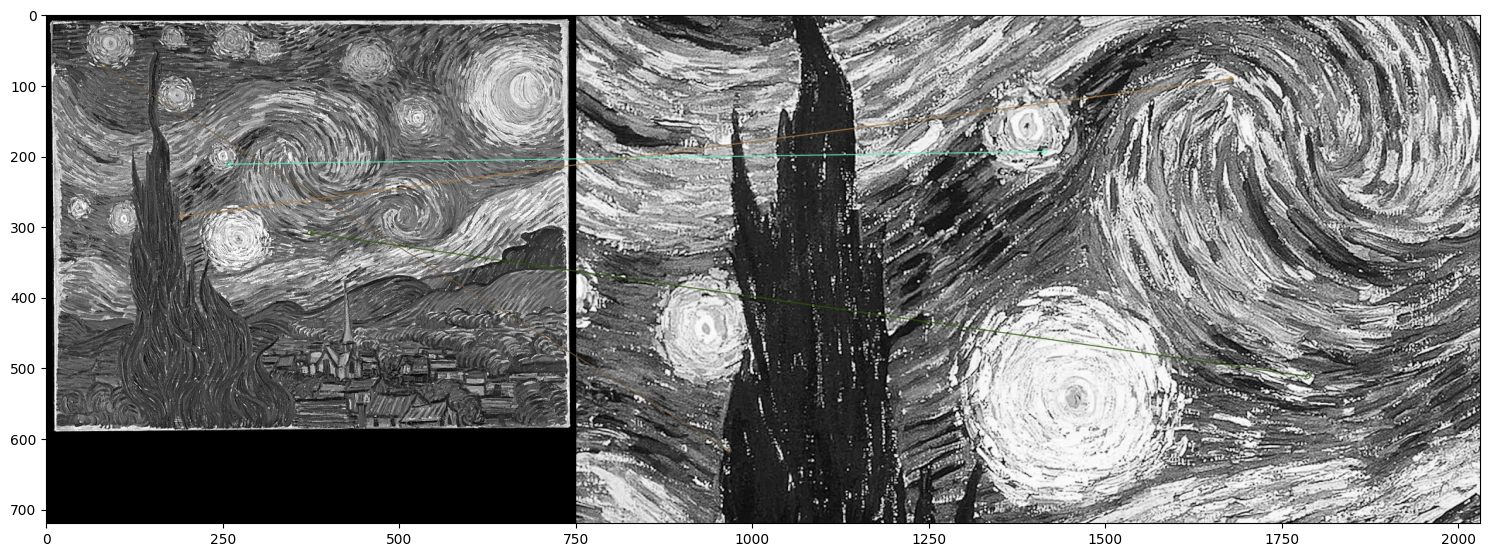

In [30]:
knn_matching(img1, kp1, img2, kp2)

# Задание.
Опираясь на справку ответьте на следующие вопросы:
- Что возвращает метод detectAndCompute()?
- Что возвращает метод drawKeypoints()?
- Что такое расстояние Хэмминга?
- Что такое дескриптор особых точек? Приведите примеры различных дескрипторов

*#your answers*

# Задание.
- Соберите коллекцию из 12 изображений различных картин художников (с повторением произведений, но все изображения должны быть разными)
- Создайте массив (список) из собранных изоборажений (по имени файла)
- Создайте несколько функций, позволяющих выполнять поиск для заданного изображения наиболее похожего изображения из коллекции, используя количество совпавших дескрипторов особых точек
- Протестируйте работу функций

In [ ]:
#your code